In [23]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from libs_unet.models import peakyfinder_0003
from libs_unet.training.libs_train import train_loop, test_loop

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [32]:
#training data load
with open(datapath / 'training' / 'el80_pairs.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)

#create dataset
#input needs a placeholder "channel" dimension since single channel
#learned labels are simply the fraction arrays
#data has to match weights which default to float() so cast data as same
#we scale spectra according so Li peak at 671 nm is 10,000 (varies by gun/source calibration)
input_mult = 0.584 #for simulated spectra using NIST libs lines data

x_data = input_mult * torch.tensor(x_data[:,None,:].astype('float32'))
y_data = torch.tensor(fracs[:,None,:].astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform input data, add small offset 1 so zero points remain ~zero on log scale
#x_data = torch.log(x_data + 1)

spec_ds = TensorDataset(x_data, y_data)
#batch sizes
train_bs = 50
test_bs = 100
#create random split for training and validation
train_len = int(0.8 * len(x_data))
test_len = len(x_data) - train_len
train_ds, test_ds = random_split(spec_ds,[train_len, test_len])
train_dl = DataLoader(train_ds, batch_size=train_bs, shuffle=True) #check if shuffle redundant
test_dl = DataLoader(test_ds, batch_size=test_bs)
#

Apply training optimization from 
 https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
 https://pytorch.org/tutorials/beginner/nn_tutorial.html
Notes: 
1. Run dataloader cell first, set batch size/file as needed
2. Simulated data is built on first n elements with 760 point spectra (190nm - 949nm)
3. Set this parameter so correct model size is built

In [26]:
#set parameters
from torch.optim import lr_scheduler

max_z = len(elem_symb)
wl_points = len(wave) #number of wavelength point measurements in data
learning_rate = 0.1 #There is a schedule to reduce as loss plateaus
#lr_patience = 10
#lr_cooldown = 2
#lr_thresh = 0.01
epochs = 10

#Initialize and run
model = peakyfinder_0003.LIBSUNet(max_z, wl_points)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = MultiStepLR(optimizer, [8], 0.5)
#lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=lr_patience,
#                                 cooldown=lr_cooldown, threshold=lr_thresh)

now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #  now 
writerpath = top_dir / 'runs' / now_time
writer = SummaryWriter(writerpath)
                            
# save trained model
#torch.save(model, top_dir / 'trained_models/peakyfinder_0001_')

#add model diagram to tensorboard
#writer.add_graph(model,train_ds)

for t in range(epochs):
    print(f"Epoch {t+1}, learning rate {optimizer.param_groups[0]['lr']}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer, writer, t+1, debug=True, bsize=train_bs)
    test_loss = test_loop(test_dl, model, loss_fn, writer, t+1)
    lr_scheduler.step()
print("Done!")

#cleanup
writer.flush()
writer.close()


Epoch 1, learning rate 0.1
-------------------------------
Epoch 2, learning rate 0.1
-------------------------------
Epoch 3, learning rate 0.1
-------------------------------
Epoch 4, learning rate 0.1
-------------------------------
Epoch 5, learning rate 0.1
-------------------------------
Epoch 6, learning rate 0.1
-------------------------------
Epoch 7, learning rate 0.1
-------------------------------
Epoch 8, learning rate 0.1
-------------------------------
Epoch 9, learning rate 0.05
-------------------------------
Epoch 10, learning rate 0.05
-------------------------------
Done!


In [27]:
#Save model parameters for use in Model_Test notebook
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
param_path = top_dir / 'trained_models' / 'el80_pairs_0001'
torch.save(model.state_dict(), param_path)

In [33]:
#look at the predicted vs. reference spectra from data set
i_samp = 2 #vary up to 
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #(1,80) # element fractions

Li:1.000000
H:0.025383
He:0.052150
Li:0.222703
B:0.078464
N:0.044418
F:0.031837
Ne:0.034651
Na:0.056478
Al:0.024303
Si:0.028066
P:0.016761
S:0.024468
Cl:0.067331
Sc:0.015692
Mn:0.042790
Zn:0.020376
Ga:0.010273
Ge:0.013243
As:0.030201
Kr:0.019517
Mo:0.036281
Ag:0.017961
Sn:0.031887
Sb:0.028146
Te:0.012759
I:0.029367
La:0.021785
Ce:0.022784
Nd:0.034270
Sm:0.013020
Eu:0.020312
Tb:0.010009
Dy:0.012313
Ho:0.021528
Er:0.015115
Lu:0.028928
Hf:0.058702
Ta:0.083498
Re:0.019027
Os:0.021855
Pt:0.037035
Au:0.014219
Pb:0.051394


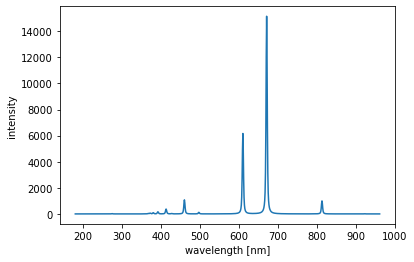

In [34]:
#Check prediction
for i in range(len(fracs[i_samp])):
    if fracs[i_samp][i] > 0:
        print(f"{elem_symb[i]}:{fracs[i_samp][i]:>4f}")

        
#first plot the transformed composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
#plt.xlim([190, 950])
plt.show

#predicted fractions
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy()
y_pred = y_pred[0]

pred_thresh = 0.01
for i in range(len(y_pred)):
    if y_pred[i] > pred_thresh:
        print(f"{elem_symb[i]}:{y_pred[i]:>4f}")
    



In [21]:
np.max(y_pred)

0.29660103

In [ ]:
#https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
def pred_plot(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out

rows = 27
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20,100), constrained_layout=True)
plot_row = 0
plot_col = 0
for i in range(max_z + 2): #iterate over rows in pred array
    if i < max_z:
        axs[plot_row][plot_col].set_title(el_symbol[i])
    elif i == max_z:
        axs[plot_row][plot_col].set_title('artifact')
    else:
            axs[plot_row][plot_col].set_title('noise')
             
        axs[plot_row][plot_col].plot(wave, y_pred[i])
        if plot_col < 2:
            plot_col += 1
        else:
            plot_col = 0
            plot_row += 1